In [1]:

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
from PIL import Image
import os
from sklearn import metrics
import glob
from torchtsmixer import TSMixer
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv("daily_data.csv")

In [3]:
df

,STATION,DATE,REPORT_TYPE,SOURCE,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,...,DailyPeakWindDirection,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,Sunrise,Sunset,WindEquipmentChangeDate
0,72518014735,2015-01-01T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,190.0,26.0,0.00,0.0,0.0,190.0,20.0,726.0,1632.0,2006-09-08
1,72518014735,2015-01-02T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,250.0,30.0,T,0.0,T,310.0,23.0,726.0,1633.0,2006-09-08
2,72518014735,2015-01-03T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,170.0,21.0,0.57,0.0,1.6,160.0,15.0,726.0,1634.0,2006-09-08
3,72518014735,2015-01-04T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,290.0,33.0,0.22,1.0,0.0,290.0,24.0,726.0,1635.0,2006-09-08
4,72518014735,2015-01-05T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6918,-73.83109,"NWS ALBANY, NY",...,280.0,42.0,T,0.0,T,290.0,32.0,726.0,1636.0,2006-09-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2663,72518014735,2022-05-27T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6812,-73.81650,"NWS ALBANY, NY",...,160.0,28.0,0.00,0,0.0,160.0,21.0,423.0,1922.0,2006-09-08
2664,72518014735,2022-05-28T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6812,-73.81650,"NWS ALBANY, NY",...,310.0,26.0,0.04,0,0.0,310.0,22.0,422.0,1923.0,2006-09-08
2665,72518014735,2022-05-29T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6812,-73.81650,"NWS ALBANY, NY",...,90.0,13.0,0.00,0,0.0,180.0,9.0,421.0,1924.0,2006-09-08
2666,72518014735,2022-05-30T23:59:00,SOD,6,PRECIP,260,PLASTIC,42.6812,-73.81650,"NWS ALBANY, NY",...,200.0,15.0,0.00,0,0.0,190.0,12.0,421.0,1925.0,2006-09-08


In [4]:
df.columns

Index(['STATION', 'DATE', 'REPORT_TYPE', 'SOURCE', 'BackupElements',
       'BackupElevation', 'BackupEquipment', 'BackupLatitude',
       'BackupLongitude', 'BackupName', 'DailyAverageDewPointTemperature',
       'DailyAverageDryBulbTemperature', 'DailyAverageRelativeHumidity',
       'DailyAverageSeaLevelPressure', 'DailyAverageStationPressure',
       'DailyAverageWetBulbTemperature', 'DailyAverageWindSpeed',
       'DailyCoolingDegreeDays', 'DailyDepartureFromNormalAverageTemperature',
       'DailyHeatingDegreeDays', 'DailyMaximumDryBulbTemperature',
       'DailyMinimumDryBulbTemperature', 'DailyPeakWindDirection',
       'DailyPeakWindSpeed', 'DailyPrecipitation', 'DailySnowDepth',
       'DailySnowfall', 'DailySustainedWindDirection',
       'DailySustainedWindSpeed', 'Sunrise', 'Sunset',
       'WindEquipmentChangeDate'],
      dtype='object')

In [5]:
df["DATE"]=pd.to_datetime(df["DATE"])

In [6]:
df.set_index('DATE',inplace=True)

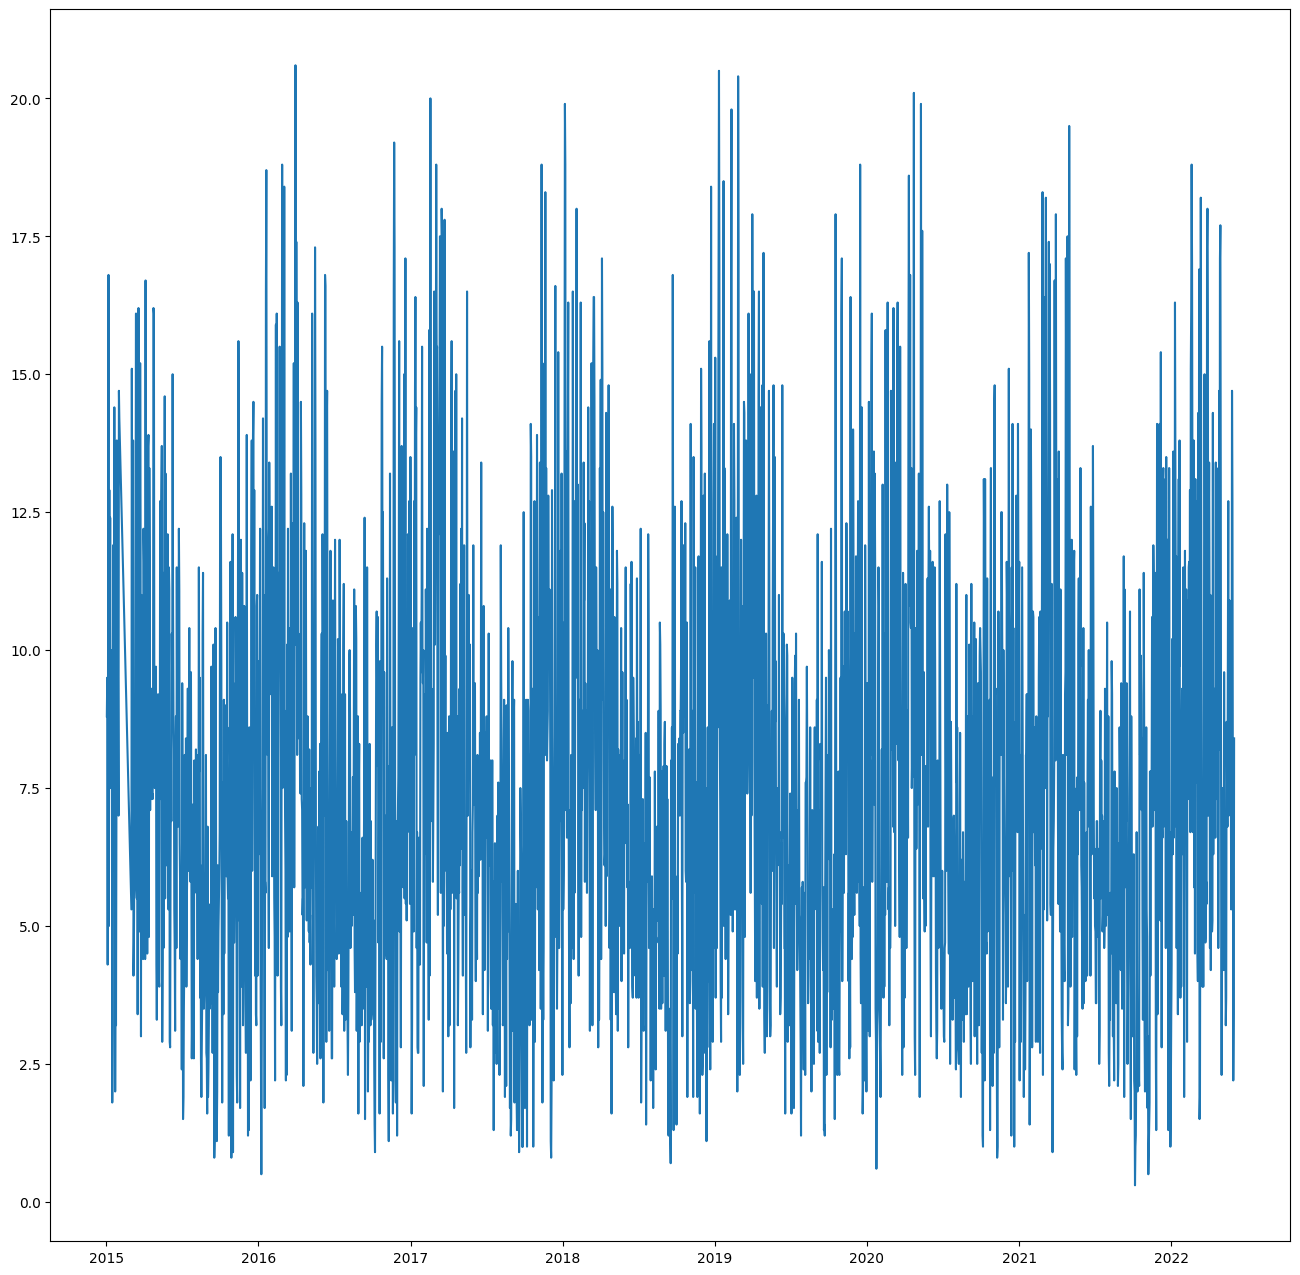

In [7]:
plt.figure(figsize=(16,16))
plt.plot(df.index,df["DailyAverageWindSpeed"])

In [8]:
data = df['DailyAverageSeaLevelPressure'].values.reshape(-1, 1)

In [9]:
data.shape

(2668, 1)

In [10]:
df.index.shape

(2668,)

In [11]:
scaler=MinMaxScaler(feature_range=(0,1))

In [12]:
data_scaled=scaler.fit_transform(data)

In [13]:
data_scaled

array([[0.48666667],
       [0.62666667],
       [0.81333333],
       ...,
       [0.52666667],
       [0.52666667],
       [0.46      ]])

In [14]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [15]:
import numpy as np
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe, sequence_length=12):
        self.data = dataframe
        self.features = dataframe["DailyAverageSeaLevelPressure"].values
        self.sequence_length = sequence_length
        
        # Özellik dizilerini ve etiketleri oluştur
        self.sequences = []
        self.labels = []

        for i in range(len(self.features) - sequence_length):
            sequence = self.features[i:i + sequence_length]
            label = self.features[i + sequence_length]  # Bir sonraki değer etiket olarak
            self.sequences.append(sequence)
            self.labels.append(label)

        self.sequences = np.array(self.sequences)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        return torch.tensor(self.sequences[index], dtype=torch.float32), torch.tensor(self.labels[index], dtype=torch.float32)


In [16]:
data_=CustomDataset(df)

In [17]:
import pandas as pd

# data_scaled'in bir DataFrame olduğunu kontrol et
print(type(df))  # Pandas DataFrame olmalı


<class 'pandas.core.frame.DataFrame'>


In [18]:
 print(df.columns)  # Sütun adlarını yazdır


Index(['STATION', 'REPORT_TYPE', 'SOURCE', 'BackupElements', 'BackupElevation',
       'BackupEquipment', 'BackupLatitude', 'BackupLongitude', 'BackupName',
       'DailyAverageDewPointTemperature', 'DailyAverageDryBulbTemperature',
       'DailyAverageRelativeHumidity', 'DailyAverageSeaLevelPressure',
       'DailyAverageStationPressure', 'DailyAverageWetBulbTemperature',
       'DailyAverageWindSpeed', 'DailyCoolingDegreeDays',
       'DailyDepartureFromNormalAverageTemperature', 'DailyHeatingDegreeDays',
       'DailyMaximumDryBulbTemperature', 'DailyMinimumDryBulbTemperature',
       'DailyPeakWindDirection', 'DailyPeakWindSpeed', 'DailyPrecipitation',
       'DailySnowDepth', 'DailySnowfall', 'DailySustainedWindDirection',
       'DailySustainedWindSpeed', 'Sunrise', 'Sunset',
       'WindEquipmentChangeDate'],
      dtype='object')


In [19]:
data.shape

(2668, 1)

In [20]:
for x , y in data_ :
    print(x.shape)
    print(y.shape)

torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Size([12])
torch.Size([])
torch.Si

In [21]:
data_[4]

(tensor([30.1200, 30.2000, 30.0000, 30.2600, 29.9900, 30.3800, 30.5300, 30.2600,
         30.6500, 30.4500, 30.0700, 29.9200]),
 tensor(30.3000))

In [22]:
train_data , test_data = train_test_split(data_, test_size=0.3)

In [23]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [24]:
print(f"Train dataset size: {len(train_data )}")
print(f"Test dataset size: {len(test_data )}")


Train dataset size: 1859
Test dataset size: 797


In [25]:
for x,y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 12])
torch.Size([32])


In [26]:
sequence_length=12
prediction_length=1
input_channels=1
output_channels=1


In [27]:
model = TSMixer(sequence_length, prediction_length, input_channels, output_channels)

In [28]:
criterion = nn.MSELoss()  # sürekli değerler için # Veya nn.L1Loss() / HuberLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
model

TSMixer(
  (mixer_layers): Sequential(
    (0): MixerLayer(
      (time_mixing): TimeMixing(
        (norm): TimeBatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (fc1): Linear(in_features=12, out_features=12, bias=True)
      )
      (feature_mixing): FeatureMixing(
        (norm_before): TimeBatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm_after): Identity()
        (dropout): Dropout(p=0.1, inplace=False)
        (fc1): Linear(in_features=1, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=1, bias=True)
        (projection): Identity()
      )
    )
  )
  (temporal_projection): Linear(in_features=12, out_features=1, bias=True)
)

In [31]:
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [33]:
model.to(device)

TSMixer(
  (mixer_layers): Sequential(
    (0): MixerLayer(
      (time_mixing): TimeMixing(
        (norm): TimeBatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (fc1): Linear(in_features=12, out_features=12, bias=True)
      )
      (feature_mixing): FeatureMixing(
        (norm_before): TimeBatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm_after): Identity()
        (dropout): Dropout(p=0.1, inplace=False)
        (fc1): Linear(in_features=1, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=1, bias=True)
        (projection): Identity()
      )
    )
  )
  (temporal_projection): Linear(in_features=12, out_features=1, bias=True)
)

In [38]:
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        x = x.unsqueeze(2)  
        #forward pass
        outputs = model(x)
        
        outputs = outputs.view(-1, output_channels)  
        y = y.view(-1, output_channels) 
        
        print("outputs shape:", outputs.shape)
        print("y shape:", y.shape)

        # Kayıp hesapla
        loss = criterion(outputs, y)

        # backward
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training complete")


outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y shape: torch.Size([32, 1])
outputs shape: torch.Size([32, 1])
y sha

Predictions shape: (797,)
True values shape: (797,)


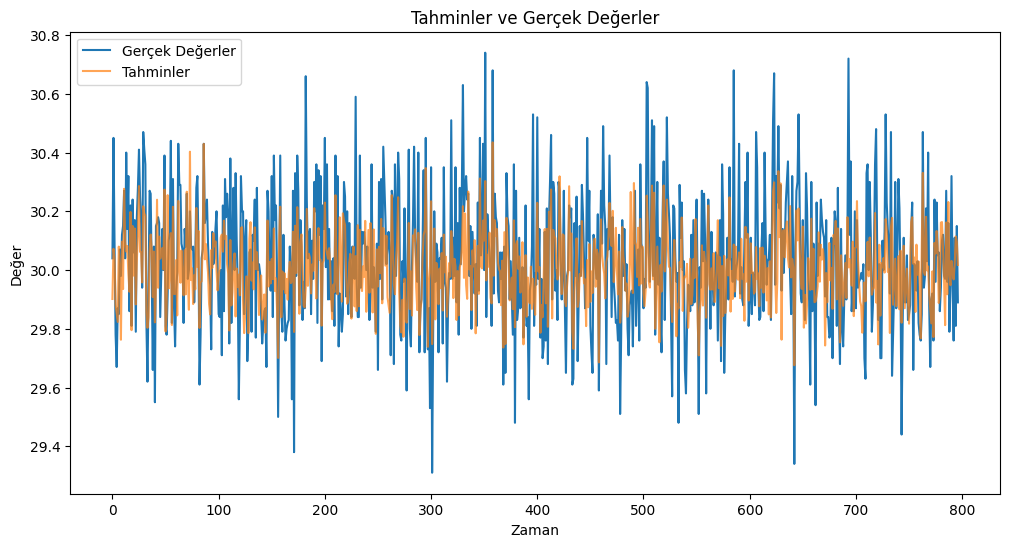

In [39]:
 
model.eval()  

predictions = []
true_values = []

with torch.no_grad():   
    for x, y in test_loader:
        x = x.to(device)   
        x = x.unsqueeze(2)   

        outputs = model(x)  # Modelden tahmin 

        predictions.append(outputs.cpu().numpy())  # Tahminleri CPU'ya taşı ve numpy dizisine ekle
        true_values.append(y.numpy())  # Gerçek değerleri numpy dizisine ekle

# Tahmin ve gerçek değerleri birleştirin
predictions = np.concatenate(predictions, axis=0).flatten()  # 1D'ye dönüştür
true_values = np.concatenate(true_values, axis=0).flatten()  # 1D'ye dönüştür

 
print("Predictions shape:", predictions.shape)
print("True values shape:", true_values.shape)

 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(true_values, label='Gerçek Değerler')
plt.plot(predictions, label='Tahminler', alpha=0.7)
plt.legend()
plt.xlabel('Zaman')
plt.ylabel('Değer')
plt.title('Tahminler ve Gerçek Değerler')
plt.show()


In [40]:

correct_predictions = 0
total_predictions = 0
model.eval()   
with torch.no_grad():   
    for x, y in test_loader:
        x = x.to(device)   
        x = x.unsqueeze(2)   
        outputs = model(x)   
        predicted_classes = torch.argmax(outputs, dim=1)  
        true_classes = y.to(device)   
        correct_predictions += (predicted_classes == true_classes).sum().item()
        total_predictions += true_classes.size(0)
accuracy = correct_predictions / total_predictions
print(f'Doğruluk: {accuracy:.4f}')


Doğruluk: 0.0000
